In [ ]:
# Imports

import os
import cv2
import glob
import shutil
import warnings
import kagglehub
import numpy as np
%matplotlib inline
import pandas as pd
from PIL import Image
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from datetime import datetime
import matplotlib.image as img
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import Model,Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.losses import MeanSquaredError
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import  Dense, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, ResNet101, ResNet152
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping

# **A) Prepare the Data and Preprocessing**

In [ ]:
# Download the Dataset
path = kagglehub.dataset_download("dasmehdixtr/drone-dataset-uav")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/drone-dataset-uav


In [ ]:
# Read the Dataset and Put it in a List (From Kaggle: Code Breaker)

train_image = []
train_annotation = []

image_file = glob.glob("/kaggle/input/drone-dataset-uav/drone_dataset_yolo/dataset_txt/*.jpg")

for i in image_file:     #slicing for insufficient memory
    Load_image = Image.open(i).convert('RGB')
    nmpy_img = Load_image.resize((256, 256))
    train_image.append(np.asarray(nmpy_img))

    seperate_path = i.split('.')
    seperate_path[1] = '.txt'

    with open(seperate_path[0]+seperate_path[1]) as f:
        lines = f.readlines()
        tmp_lst = lines[0].split(' ')
        #label = int(tmp_lst[0])
        startX = float(tmp_lst[1])
        startY = float(tmp_lst[2])
        endX = float(tmp_lst[3])
        endY = float(tmp_lst[4])
        train_annotation.append((startX, startY, endX, endY))

1359


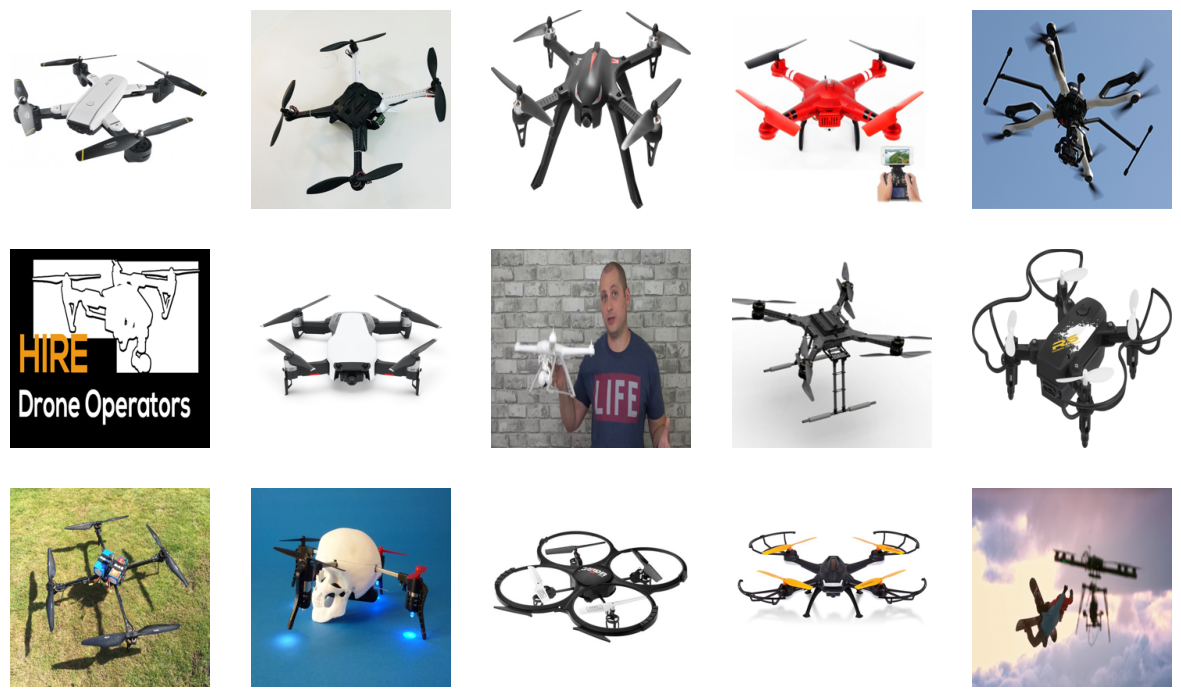

In [ ]:
# Visualize the Data

print(len(train_image))

plt.figure(figsize=(15, 15))

for i in range(15):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(train_image[i].astype("uint8"))
    plt.axis("off")

In [ ]:
# Nomralization and change it from List to Numpy array
data = np.array(train_image, dtype='float32') / 255.0
targets = np.array(train_annotation, dtype='float32')

In [ ]:
print(data.shape)
print(targets.shape)

(1359, 256, 256, 3)
(1359, 4)


In [ ]:
# Split the Data Into Train and Test
trainImages, testImages, trainTargets, testTargets = train_test_split(data, targets, test_size=0.20, random_state=42)

In [ ]:
print(trainImages.shape)
print(trainTargets.shape)
print(testImages.shape)
print(testTargets.shape)

(1087, 256, 256, 3)
(1087, 4)
(272, 256, 256, 3)
(272, 4)


In [ ]:
# Data Augmenatation

# Augmentation Function Take (Images, Targets of the Images)
def augment_images_and_targets(images, targets):

    # List to store augmented images
    augmented_images = []

    # List to store augmented labels
    augmented_targets = []

    for image, target in zip(images, targets):
        # Horizontal flip
        flipped = np.fliplr(image)

        # Rotation
        rotated = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)

        # Add the augmented images and their corresponding targets
        augmented_images.extend([image, flipped, rotated])

        # Add the Same Label to all 4 images
        augmented_targets.extend([target, target, target])

    return np.array(augmented_images), np.array(augmented_targets)


# Apply augmentation to both images and targets
augmented_train_images, augmented_train_targets = augment_images_and_targets(trainImages, trainTargets)

print(f"Original images shape: {trainImages.shape}, Original targets shape: {trainTargets.shape}")
print(f"Augmented images shape: {augmented_train_images.shape}, Augmented targets shape: {augmented_train_targets.shape}")

Original images shape: (1087, 256, 256, 3), Original targets shape: (1087, 4)
Augmented images shape: (3261, 256, 256, 3), Augmented targets shape: (3261, 4)


# **B) Model Architecture**

In [ ]:
# Download VGG16 Model
IMAGE_SIZE = [256, 256, 3]
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=IMAGE_SIZE)

In [ ]:
# Fine Tuning
for layer in base_model.layers[-10:]:
    layer.trainable = True

In [ ]:
# Adding the Fully Connected layers

inputs = tf.keras.Input(shape=(256, 256, 3))

x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Add Flatten layer
x =  tf.keras.layers.Flatten()(x)


x =  tf.keras.layers.Dense(64, activation="relu")(x)
#x = Dropout(0.3)(x)
#x =  tf.keras.layers.Dense(32, activation="relu")(x)

# Ouput layer with 4 Neurons
outputs = tf.keras.layers.Dense(4, activation = "linear")(x)

# Build the Model
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 6, 6, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,934,180 (83.67 MB)

 Trainable params: 21,899,748 (83.54 MB)

 Non-trainable params: 34,432 (134.50 KB)

# **C) Training and Evaluation**

In [ ]:
# Choosing Adam Optimizer
adam = optimizers.Adam()

# Compile
model.compile(optimizer=Adam(), loss=MeanSquaredError(), metrics=['accuracy'])

In [ ]:
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

# Train the model
model_history = model.fit(
    augmented_train_images,
    augmented_train_targets,
    validation_split=0.2,
    epochs=150,
    batch_size= 32,
    callbacks=[early_stopping],
    verbose=2
)

Epoch 1/150


I0000 00:00:1734203774.807799      93 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion', 32 bytes spill stores, 32 bytes spill loads

I0000 00:00:1734203828.796871      96 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion', 32 bytes spill stores, 32 bytes spill loads



82/82 - 121s - 1s/step - accuracy: 0.6729 - loss: 0.0434 - val_accuracy: 0.6508 - val_loss: 0.1134
Epoch 2/150
82/82 - 34s - 413ms/step - accuracy: 0.7703 - loss: 0.0109 - val_accuracy: 0.7305 - val_loss: 0.0272
Epoch 3/150
82/82 - 32s - 396ms/step - accuracy: 0.8148 - loss: 0.0073 - val_accuracy: 0.7596 - val_loss: 0.0142
Epoch 4/150
82/82 - 31s - 380ms/step - accuracy: 0.8290 - loss: 0.0055 - val_accuracy: 0.7933 - val_loss: 0.0157
Epoch 5/150
82/82 - 33s - 401ms/step - accuracy: 0.8631 - loss: 0.0041 - val_accuracy: 0.7871 - val_loss: 0.0119
Epoch 6/150
82/82 - 32s - 391ms/step - accuracy: 0.8543 - loss: 0.0037 - val_accuracy: 0.8300 - val_loss: 0.0111
Epoch 7/150
82/82 - 32s - 388ms/step - accuracy: 0.8658 - loss: 0.0040 - val_accuracy: 0.7979 - val_loss: 0.0129
Epoch 8/150
82/82 - 32s - 394ms/step - accuracy: 0.8777 - loss: 0.0034 - val_accuracy: 0.8208 - val_loss: 0.0093
Epoch 9/150
82/82 - 32s - 390ms/step - accuracy: 0.8861 - loss: 0.0028 - val_accuracy: 0.8285 - val_loss: 0.00

In [ ]:
# Testing or Prediction
predictions = model.predict(testImages)

9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 655ms/step


In [ ]:
print(predictions[21])
print(testTargets[21])

[0.35744652 0.548958   0.40362608 0.28522608]
[0.329 0.512 0.426 0.254]


# **D) Visualization of Results**

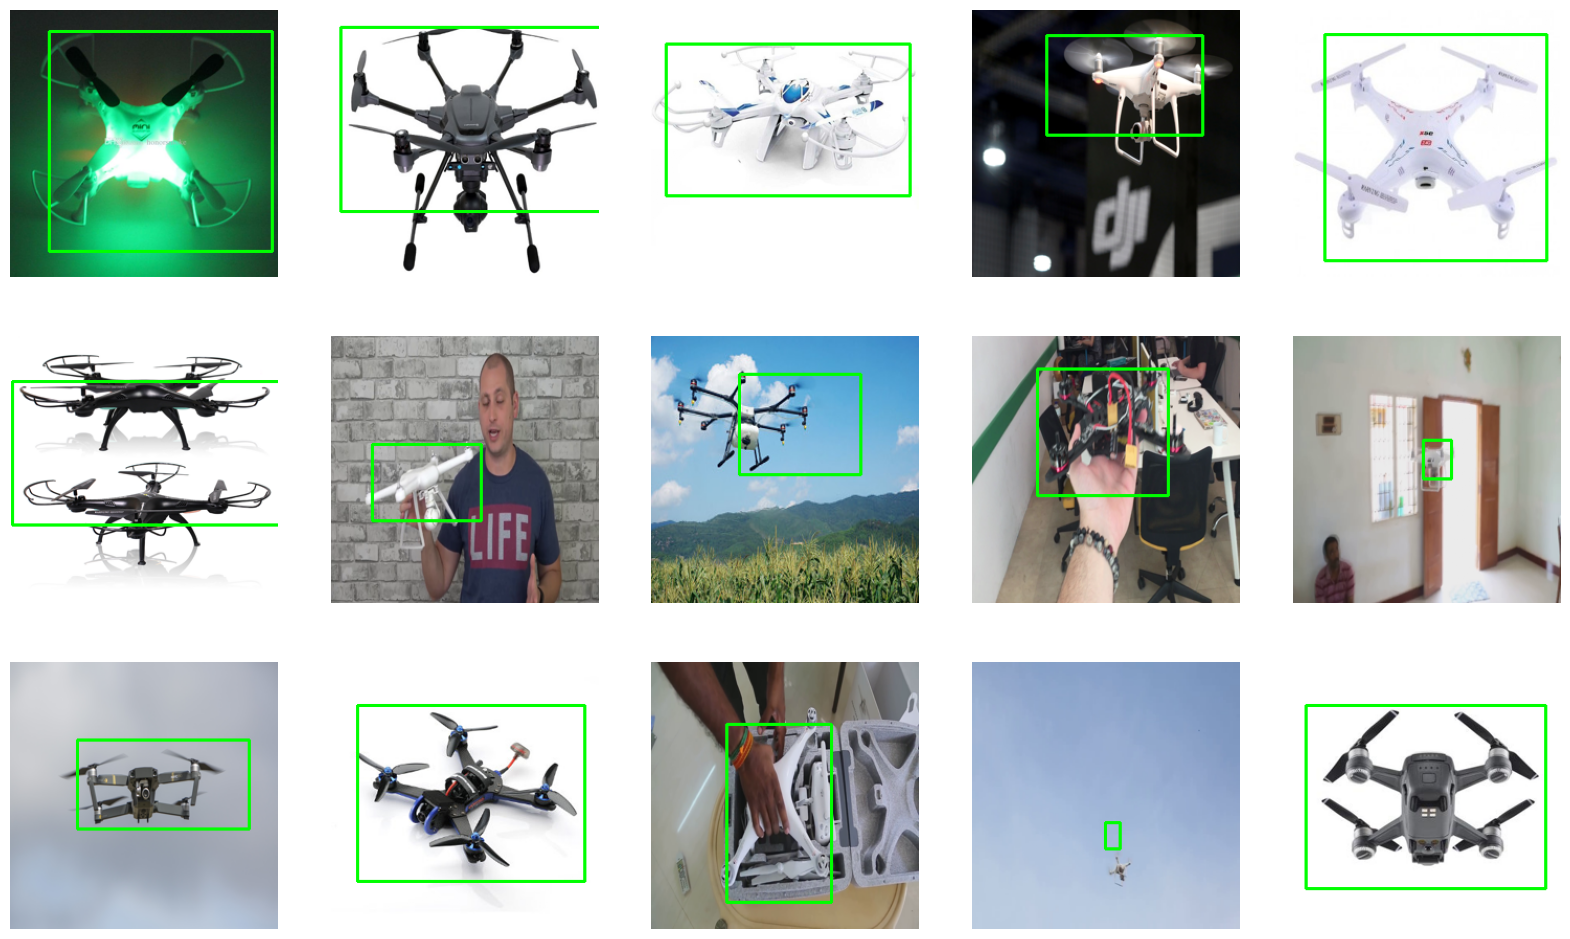

In [ ]:
# Number of images to show
num_images = 15

# Set up a grid for displaying the images
fig, axes = plt.subplots(3, 5, figsize=(20, 12))  # 3 rows, 5 columns
axes = axes.ravel()

# Loop over the images
for i in range(num_images):

    image_idx = i+15 # The index of Image that i will Show
    image = testImages[image_idx].copy()  # Get a copy from the image, Dont change in the original image
    predicted_box = predictions[image_idx]  # Get the predicted bounding box [x_center, y_center, width, height]

    # Get image dimensions
    height, width, _ = image.shape

    # Get the bounding box values from the prediction
    x_center, y_center, box_width, box_height = predicted_box

    # Scale normalized values (0,1) to pixel values
    x_center *= width
    y_center *= height
    box_width *= width
    box_height *= height

    # Convert from center to top-left and bottom-right coordinates
    x1 = int(x_center - box_width / 2)  # Top-left x
    y1 = int(y_center - box_height / 2)  # Top-left y
    x2 = int(x_center + box_width / 2)  # Bottom-right x
    y2 = int(y_center + box_height / 2)  # Bottom-right y

    # Draw the bounding box
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # Display the image in the grid
    axes[i].imshow(image)
    axes[i].axis('off')

plt.show()

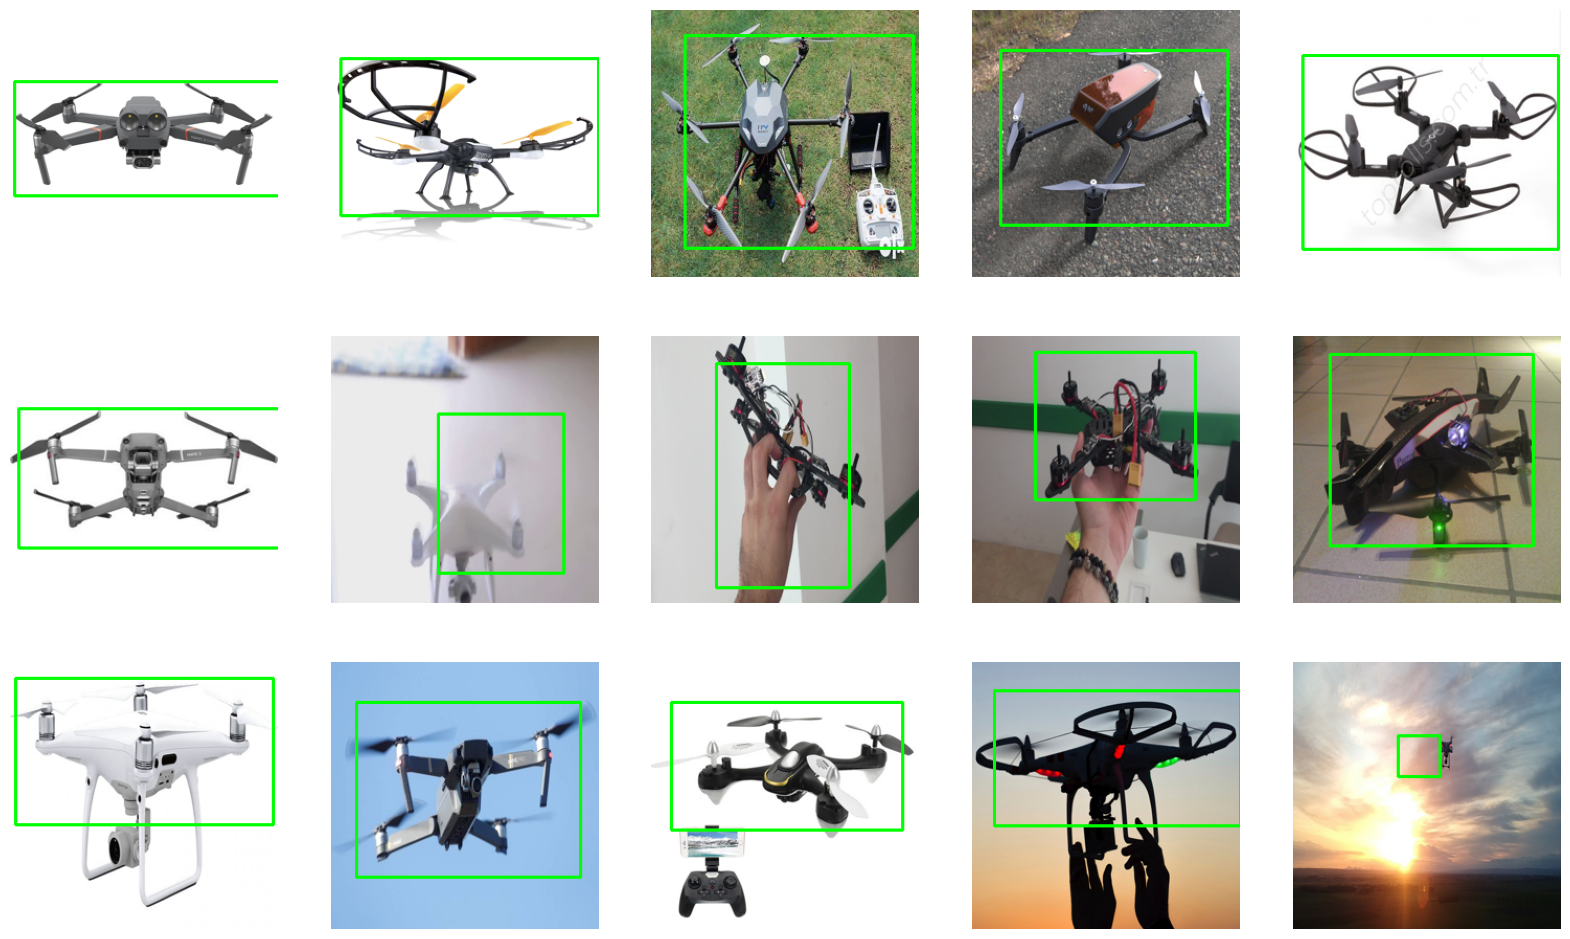

In [ ]:
# Number of images to show
num_images = 15

# Set up a grid for displaying the images
fig, axes = plt.subplots(3, 5, figsize=(20, 12))  # 3 rows, 5 columns
axes = axes.ravel()

# Loop over the images
for i in range(num_images):

    image_idx = i # The index of Image that i will Show
    image = testImages[image_idx].copy()  # Get a copy from the image, Dont change in the original image
    predicted_box = predictions[image_idx]  # Get the predicted bounding box [x_center, y_center, width, height]

    # Get image dimensions
    height, width, _ = image.shape

    # Get the bounding box values from the prediction
    x_center, y_center, box_width, box_height = predicted_box

    # Scale normalized values (0,1) to pixel values
    x_center *= width
    y_center *= height
    box_width *= width
    box_height *= height

    # Convert from center to top-left and bottom-right coordinates
    x1 = int(x_center - box_width / 2)  # Top-left x
    y1 = int(y_center - box_height / 2)  # Top-left y
    x2 = int(x_center + box_width / 2)  # Bottom-right x
    y2 = int(y_center + box_height / 2)  # Bottom-right y

    # Draw the bounding box
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # Display the image in the grid
    axes[i].imshow(image)
    axes[i].axis('off')

plt.show()

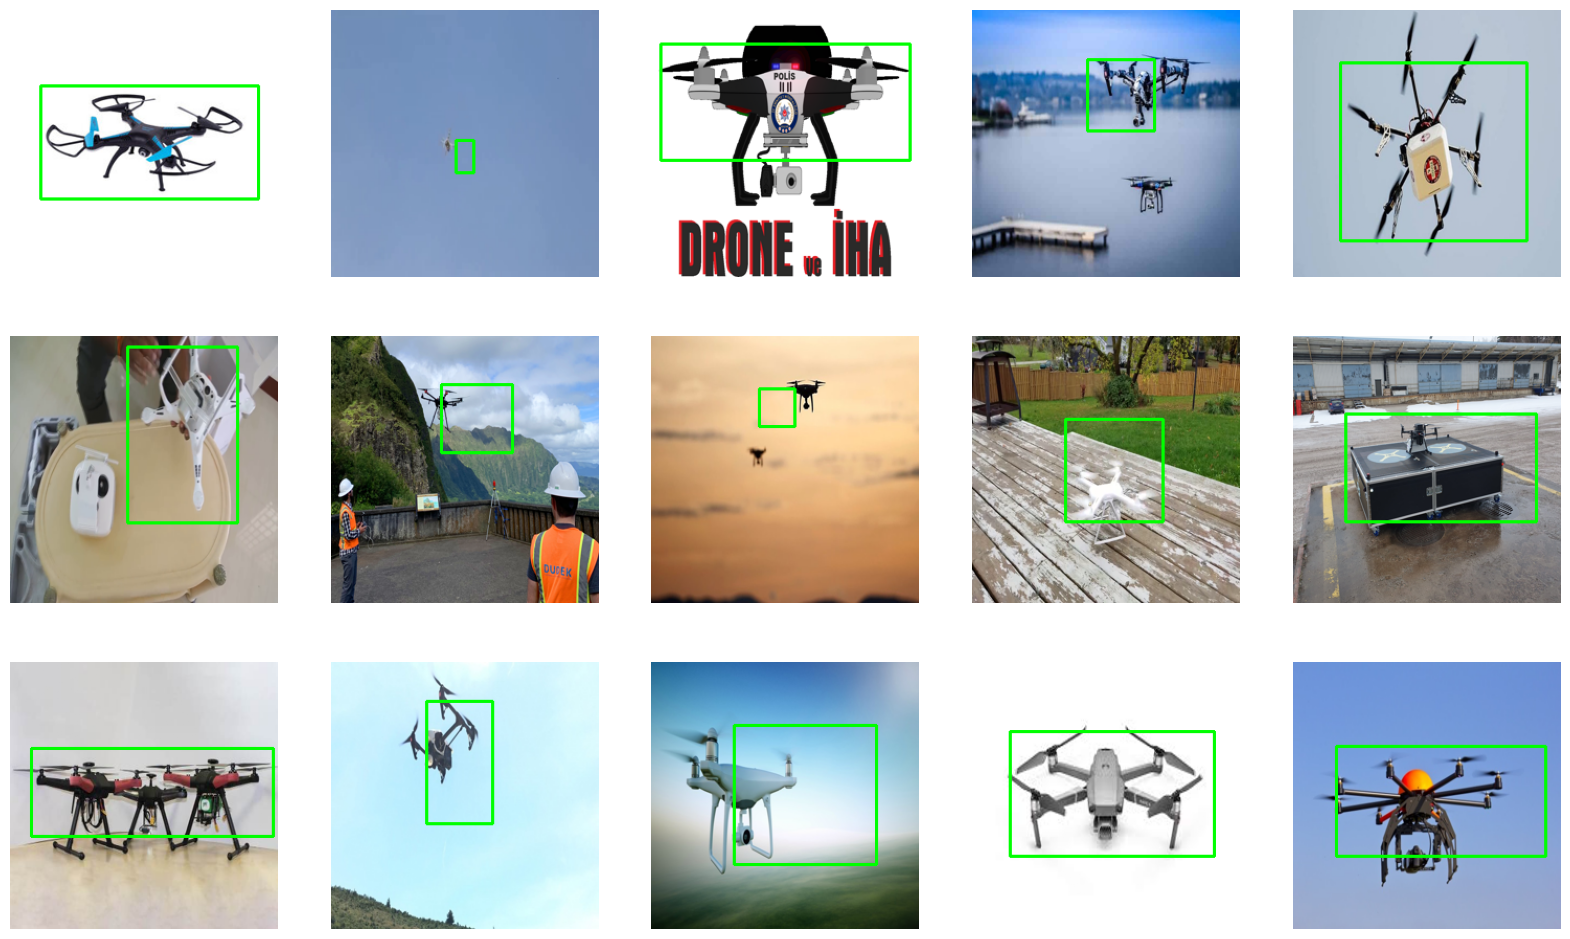

In [ ]:
# Number of images to show
num_images = 15

# Set up a grid for displaying the images
fig, axes = plt.subplots(3, 5, figsize=(20, 12))  # 3 rows, 5 columns
axes = axes.ravel()

# Loop over the images
for i in range(num_images):

    image_idx = i+130 # The index of Image that i will Show
    image = testImages[image_idx].copy()  # Get a copy from the image, Dont change in the original image
    predicted_box = predictions[image_idx]  # Get the predicted bounding box [x_center, y_center, width, height]

    # Get image dimensions
    height, width, _ = image.shape

    # Get the bounding box values from the prediction
    x_center, y_center, box_width, box_height = predicted_box

    # Scale normalized values (0,1) to pixel values
    x_center *= width
    y_center *= height
    box_width *= width
    box_height *= height

    # Convert from center to top-left and bottom-right coordinates
    x1 = int(x_center - box_width / 2)  # Top-left x
    y1 = int(y_center - box_height / 2)  # Top-left y
    x2 = int(x_center + box_width / 2)  # Bottom-right x
    y2 = int(y_center + box_height / 2)  # Bottom-right y

    # Draw the bounding box
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # Display the image in the grid
    axes[i].imshow(image)
    axes[i].axis('off')

plt.show()

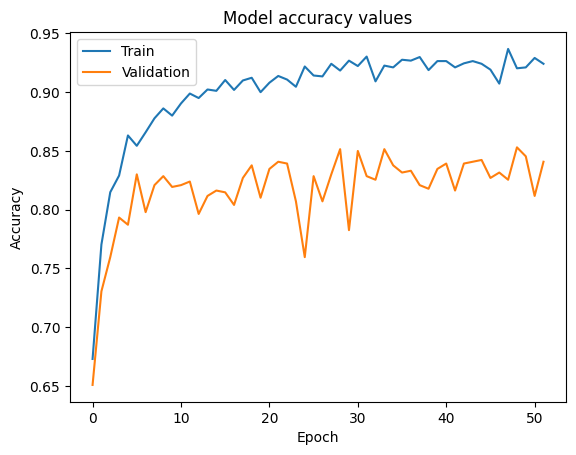

In [ ]:
# Plot training and validation Accuracy values
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model accuracy values')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

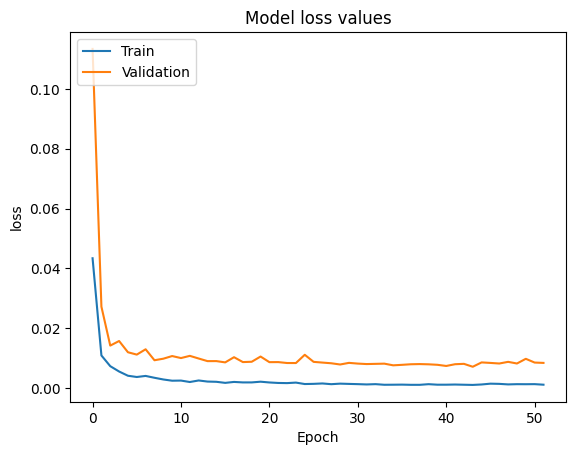

In [ ]:
# Plot training and validation loss values
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model loss values')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# **Bonus**

## **First Dataset**

In [ ]:
# Download Dataset
path = kagglehub.dataset_download("imbikramsaha/drone-bird-classification")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/drone-bird-classification


In [ ]:
# Correct path to the dataset in Kaggle
image_dir = "/kaggle/input/drone-bird-classification/drone_or_bird/drones"

# Initialize a list to store the images
images = []

# Load and preprocess up to 15 images
for idx, filename in enumerate(os.listdir(image_dir)):
    file_path = os.path.join(image_dir, filename)
    if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp')):
        # Load the image
        image = cv2.imread(file_path)
        # Convert BGR (OpenCV default) to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # Resize the image (optional, e.g., to 224x224 for consistency)
        image = cv2.resize(image, (256, 256))
        # Add to the list
        images.append(image)


# Convert list to NumPy array
images_array = np.array(images)

# Check the number of images loaded
print(f"Loaded {len(images_array)} images.")

libpng warning: iCCP: known incorrect sRGB profile


Loaded 160 images.


In [ ]:
data2 = np.array(images_array, dtype='float32') / 255.0

In [ ]:
# Testing or Prediction
predictions2 = model.predict(data2[:100])

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step  


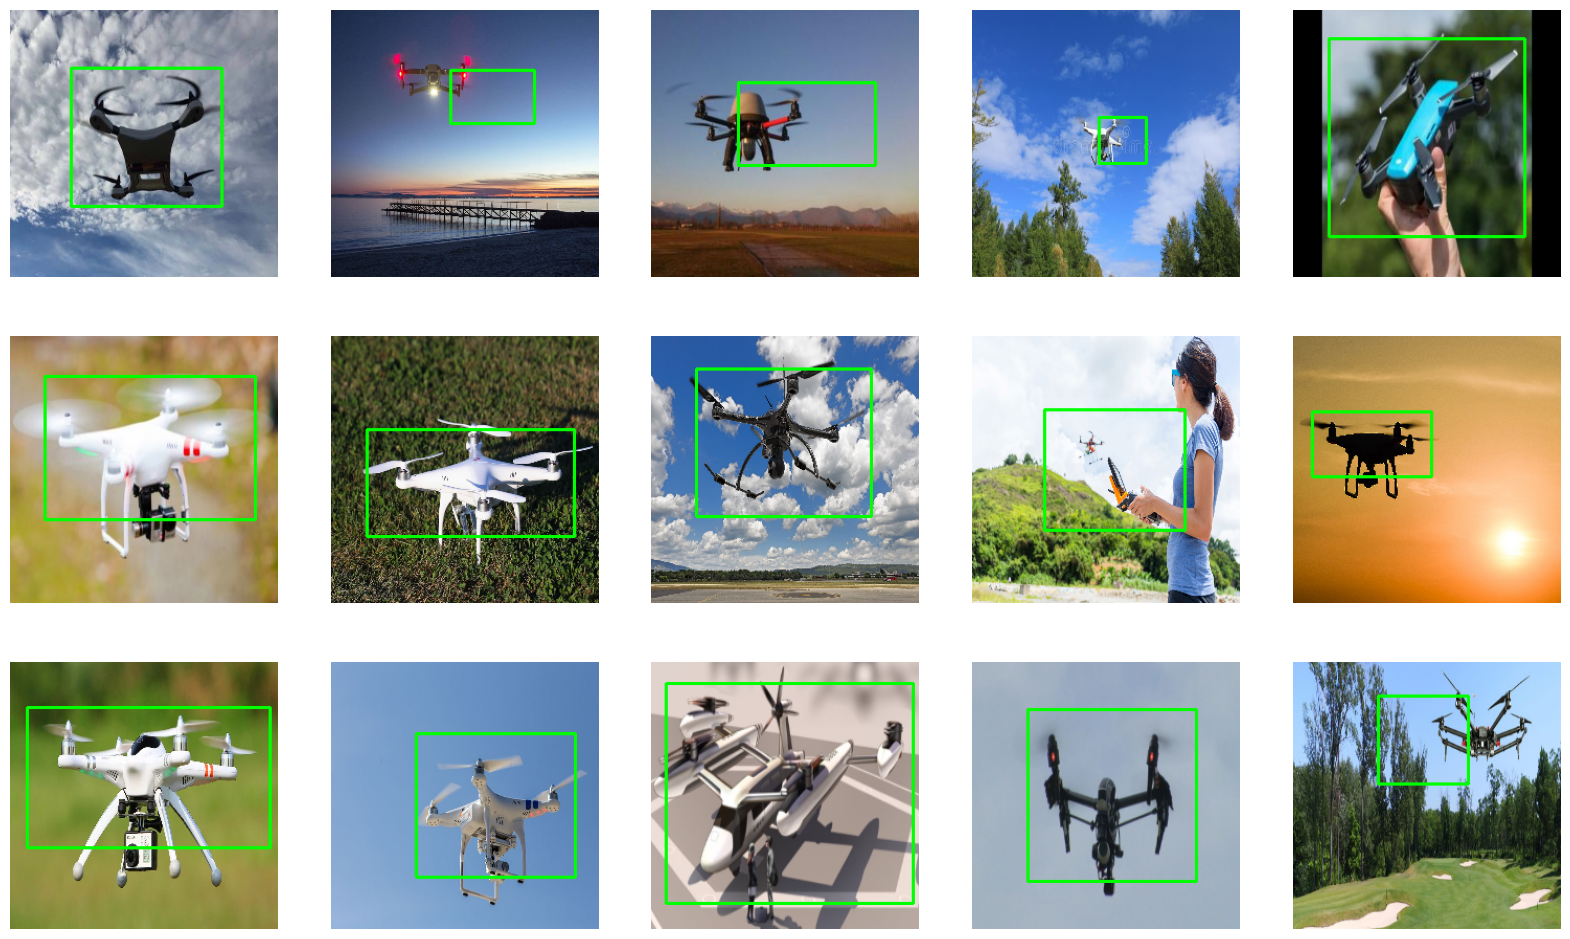

In [ ]:
# Number of images to show
num_images = 15

# Set up a grid for displaying the images
fig, axes = plt.subplots(3, 5, figsize=(20, 12))  # 3 rows, 5 columns
axes = axes.ravel()

# Loop over the images
for i in range(num_images):

    image_idx = i # The index of Image that i will Show
    image = images_array[image_idx].copy()  # Get a copy from the image, Dont change in the original image
    predicted_box = predictions2[image_idx]  # Get the predicted bounding box [x_center, y_center, width, height]

    # Get image dimensions
    height, width, _ = image.shape

    # Get the bounding box values from the prediction
    x_center, y_center, box_width, box_height = predicted_box

    # Scale normalized values (0,1) to pixel values
    x_center *= width
    y_center *= height
    box_width *= width
    box_height *= height

    # Convert from center to top-left and bottom-right coordinates
    x1 = int(x_center - box_width / 2)  # Top-left x
    y1 = int(y_center - box_height / 2)  # Top-left y
    x2 = int(x_center + box_width / 2)  # Bottom-right x
    y2 = int(y_center + box_height / 2)  # Bottom-right y

    # Draw the bounding box
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # Display the image in the grid
    axes[i].imshow(image)
    axes[i].axis('off')

plt.show()

## **Second Data**

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mcagriaksoy/amateur-unmanned-air-vehicle-detection-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/amateur-unmanned-air-vehicle-detection-dataset


In [ ]:
import os
import numpy as np
from PIL import Image
import glob
from PIL import Image, UnidentifiedImageError

# Initialize a list to store images
train_image = []

# Path to the directory where the images are stored
image_file = glob.glob("/kaggle/input/amateur-unmanned-air-vehicle-detection-dataset/Database1/Database1/*.JPEG")


for i in image_file:  # Loop through each .JPEG image file
    try:
        # Try opening and converting the image
        Load_image = Image.open(i).convert('RGB')
        nmpy_img = np.asarray(Load_image.resize((256, 256)))  # Resize image and convert to numpy array
        train_image.append(nmpy_img)  # Append the image to the list
    except (UnidentifiedImageError, OSError) as e:
        # Skip the file if it cannot be opened as an image
        print(f"Skipping file: {i}, error: {e}")

Skipping file: /kaggle/input/amateur-unmanned-air-vehicle-detection-dataset/Database1/Database1/video17_295.JPEG, error: cannot identify image file '/kaggle/input/amateur-unmanned-air-vehicle-detection-dataset/Database1/Database1/video17_295.JPEG'
Skipping file: /kaggle/input/amateur-unmanned-air-vehicle-detection-dataset/Database1/Database1/video15_487.JPEG, error: image file is truncated (5 bytes not processed)
Skipping file: /kaggle/input/amateur-unmanned-air-vehicle-detection-dataset/Database1/Database1/video19_1900.JPEG, error: cannot identify image file '/kaggle/input/amateur-unmanned-air-vehicle-detection-dataset/Database1/Database1/video19_1900.JPEG'


In [ ]:
# Convert the list of images to a numpy array
data3 = np.array(train_image, dtype='float32') / 255.0

# Optional: Check the shape of the resulting array
print(f"Shape of train_images_array: {data3.shape}")

Shape of train_images_array: (4009, 256, 256, 3)


In [ ]:
predictions3 = model.predict(data3[:100])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


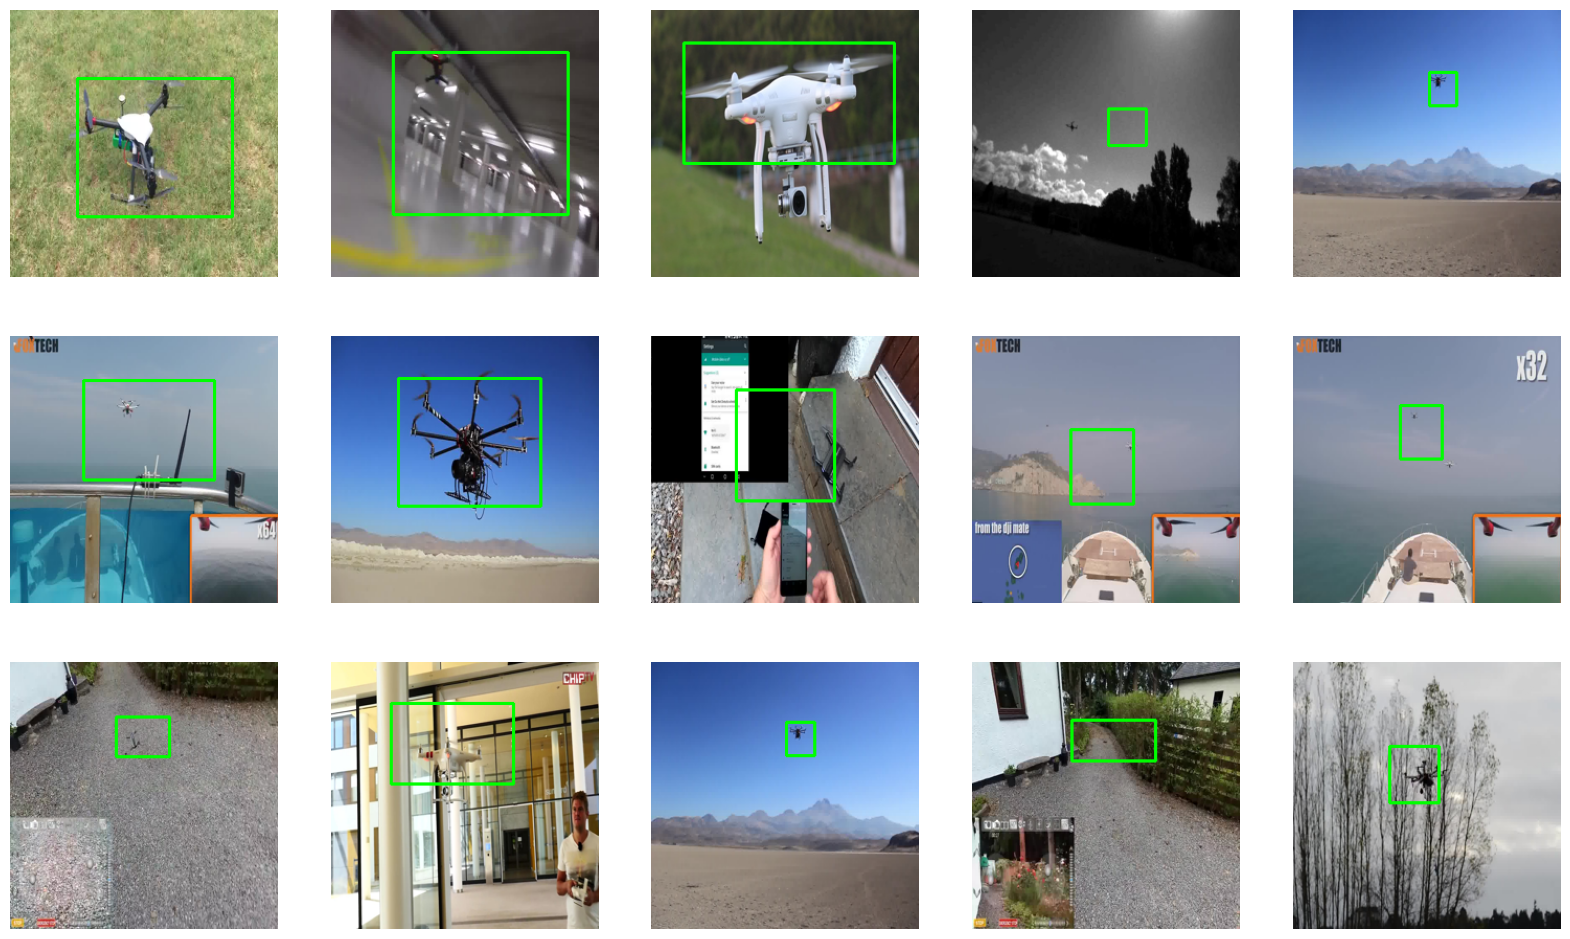

In [ ]:
# Number of images to show
num_images = 15

# Set up a grid for displaying the images
fig, axes = plt.subplots(3, 5, figsize=(20, 12))  # 3 rows, 5 columns
axes = axes.ravel()

# Loop over the images
for i in range(num_images):

    image_idx = i + 75 # The index of Image that i will Show
    image = data3[image_idx].copy()  # Get a copy from the image, Dont change in the original image
    predicted_box = predictions3[image_idx]  # Get the predicted bounding box [x_center, y_center, width, height]

    # Get image dimensions
    height, width, _ = image.shape

    # Get the bounding box values from the prediction
    x_center, y_center, box_width, box_height = predicted_box

    # Scale normalized values (0,1) to pixel values
    x_center *= width
    y_center *= height
    box_width *= width
    box_height *= height

    # Convert from center to top-left and bottom-right coordinates
    x1 = int(x_center - box_width / 2)  # Top-left x
    y1 = int(y_center - box_height / 2)  # Top-left y
    x2 = int(x_center + box_width / 2)  # Bottom-right x
    y2 = int(y_center + box_height / 2)  # Bottom-right y

    # Draw the bounding box
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # Display the image in the grid
    axes[i].imshow(image)
    axes[i].axis('off')

plt.show()